<a href="https://colab.research.google.com/github/bobbercheng/ventilator-pressure-prediction/blob/master/gb_vpp_why_so_serious.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pandas==1.3.2

In [2]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [3]:
!pip install kaggle
!mkdir /root/.kaggle
!cp /gdrive/MyDrive/ventilator-pressure-prediction/kaggle.json /root/.kaggle
!kaggle competitions download -c ventilator-pressure-prediction
!mkdir -p /kaggle/input/ventilator-pressure-prediction
!unzip '*.zip' -d /kaggle/input/ventilator-pressure-prediction
!ls /kaggle/input/ventilator-pressure-prediction

 88% 66.0M/75.4M [00:00<00:00, 78.4MB/s]
100% 75.4M/75.4M [00:01<00:00, 77.7MB/s]
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 78.1MB/s]
 88% 122M/139M [00:00<00:00, 138MB/s]
100% 139M/139M [00:00<00:00, 151MB/s]
Archive:  test.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/test.csv  

Archive:  sample_submission.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/sample_submission.csv  

Archive:  train.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/train.csv  

3 archives were successfully processed.
sample_submission.csv  test.csv  train.csv


## Import libraries

In [4]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, Add, GRU

np.random.seed(42)
tf.random.set_seed(42)

## Load source datasets

In [6]:
train_df = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [7]:
test_df = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


## Feature Engineering

In [8]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-5...Completed")
    
    return df


print("Train data...\n")
train = add_features(train_df)

print("\nTest data...\n")
test = add_features(test_df)

del train_df
del test_df
gc.collect()

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed


22

In [9]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

In [10]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 53) 
test: (50300, 80, 53) 
targets: (75450, 80)


## Hardware config

In [11]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.99.111.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.99.111.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.99.111.218:8470
Batch Size: 512


## Keras DNN Model

In [12]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=256, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=128, return_sequences=True))(x3)
    
    z2 = Bidirectional(GRU(units=256, return_sequences=True))(x2)
    z3 = Bidirectional(GRU(units=128, return_sequences=True))(Add()([x3, z2]))
    z4 = Bidirectional(GRU(units=64, return_sequences=True))(Add()([x4, z3]))
    
    x = Concatenate(axis=2)([x4, z2, z3, z4])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [13]:
model = dnn_model()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 53)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 1536)     5050368     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     8392704     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 512)      2623488     bidirectional_1[0][0]            
__________________________________________________________________________________________

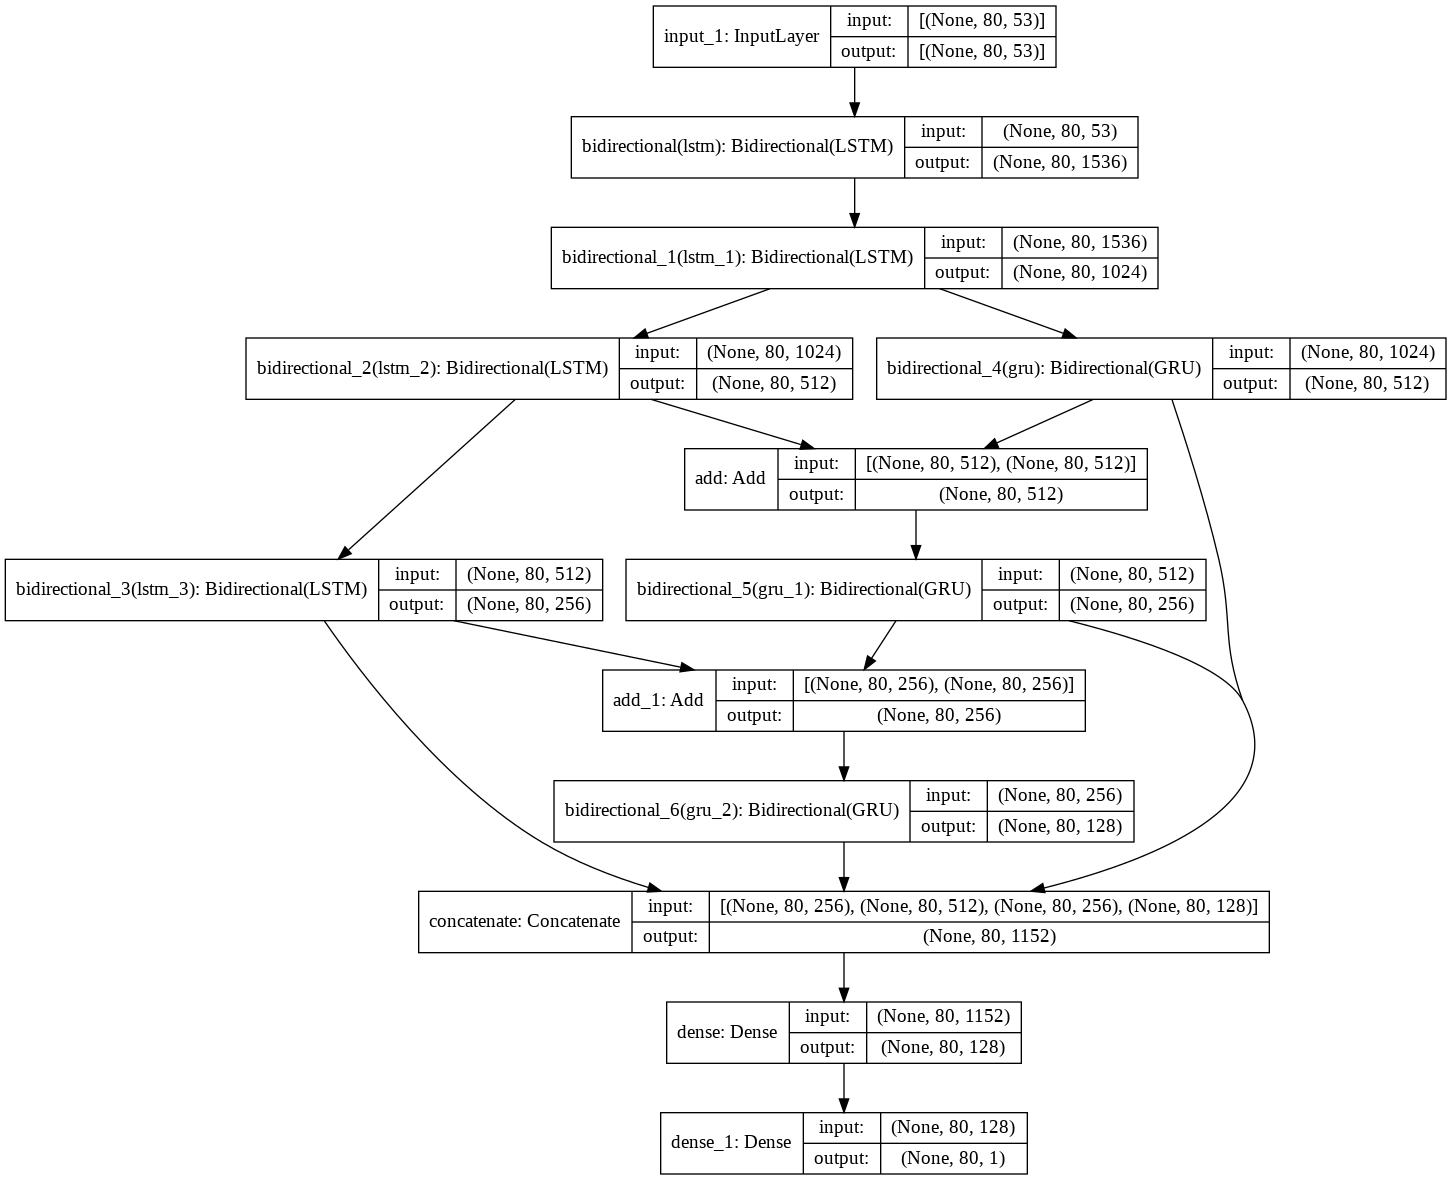

In [14]:
plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [16]:
with tpu_strategy.scope():
    
    VERBOSE = 1
    test_preds = []
    train_preds = []
    kf = KFold(n_splits=5, shuffle=True, random_state=2021)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        model = dnn_model()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        
        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        checkpoint_name = f'./Bidirect_LSTM_model_{fold+1}C.h5'
        chk_point = ModelCheckpoint(checkpoint_name, options=save_locally, 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50, 
                           verbose=VERBOSE, mode="min", 
                           restore_best_weights=True)
        
        model.fit(X_train, y_train, 
                  validation_data=(X_valid, y_valid), 
                  epochs=300,
                  verbose=VERBOSE,
                  batch_size=BATCH_SIZE, 
                  callbacks=[lr, chk_point, es])
        
        load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        model = load_model(checkpoint_name, options=load_locally)
        with open('/gdrive/MyDrive/ventilator-pressure-prediction/'+checkpoint_name, 'wb') as f:
          f.write(open(checkpoint_name, 'rb').read())
        
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        score = mean_absolute_error(y_true, y_pred)
        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())
        train_preds.append(model.predict(train, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

Epoch 1/300
118/118 [==============================] - 140s 818ms/step - loss: 1.6704 - val_loss: 0.7598

Epoch 00001: val_loss improved from inf to 0.75979, saving model to ./Bidirect_LSTM_model_1C.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
118/118 [==============================] - 57s 485ms/step - loss: 0.6860 - val_loss: 0.6186

Epoch 00002: val_loss improved from 0.75979 to 0.61860, saving model to ./Bidirect_LSTM_model_1C.h5
Epoch 3/300
118/118 [==============================] - 57s 485ms/step - loss: 0.5673 - val_loss: 0.6173

Epoch 00003: val_loss improved from 0.61860 to 0.61734, saving model to ./Bidirect_LSTM_model_1C.h5
Epoch 4/300
118/118 [==============================] - 57s 485ms/step - loss: 0.5079 - val_loss: 0.4738

Epoch 00004: val_loss improved from 0.61734 to 0.47382, saving model to ./Bidirect_LSTM_model_1C.h5
Epoch 5/300
118/118 [==============================] - 57s 485ms/step - loss: 0.4802 - val_loss: 0.4335

Epoch 00005: val_loss improved from 0.47382 to 0.43348, saving model to ./Bidirect_LSTM_model_1C.h5
Epoch 6/300
118/118 [==============================] - 57s 486ms/step - loss: 0.4235 - val_loss: 0.3987

Epoch 00006: val_loss improved from 0.43348 to 0.39872, saving model to ./B

NameError: ignored

## Create submission file

In [ ]:
submission = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/sample_submission.csv')
submission["pressure"] = sum(test_preds)/5
submission.to_csv('submission.csv', index=False)

In [ ]:
submission["pressure"] = sum(train_preds)/5
submission.to_csv('submission_train.csv', index=False)

In [ ]:
!zip cnn_models.zip *.hdf5
!zip submission.zip *.csv

In [ ]:
with open('/gdrive/MyDrive/ventilator-pressure-prediction/submission.zip', 'wb') as f:
  f.write(open('submission.zip', 'rb').read())

with open('/gdrive/MyDrive/ventilator-pressure-prediction/cnn_models.zip', 'wb') as f:
  f.write(open('cnn_models.zip', 'rb').read())